# Cycle computation & Apertium RDF dictionaries. Analysing potential targets.

This is a quick analysis of the potential targets we get when running the experiment on all English nouns in the Apertium RDF data (Targets-EN.txt). See the README file to know how the data were generated.

For each source-target pair: the target word is the index of the data frame and the columns correspond to:

    Word: the source English word.
    Cycles: the number of cycles with source & target words.
    Cycles_U: number of 'unique' cycles with source & target words (abcda = acdba).
    Nodes: number of nodes in the Word graph (the local context for Word).
    Edges: number of edges in the Word graph (the local context for Word).
    Targets: number of already known targets for Word in the Apertium data.
    pT: number of potential targets for Word (nodes in cycles not linked to Word).
    Graph_D: graph density (density of the context).
    Lan: indicates whether there is another Target word with same language.
    Score: the cycle's density.
    InC: the number of cycles the Target word occurs in with the same score.
    length: the length of the cycle.
    Target_lang: the target language.

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import stats

# Read input file 'Targets-EN.txt', drop possible duplicates and name columns
df = pd.read_csv('Targets-EN.txt', header=None)
#print(df.head())
df = df.drop_duplicates()
df.columns = ['Word', 'Cycles', 'Cycles_U', 'Nodes', 'Edges', 'Targets', 'pT', 
              'Graph_D', 'Target_ID', 'Lan','Score','InC','length']

# Split target word (Target_ID) to generate Target_lang column
df['Target'], df['Target_Lang'] = df['Target_ID'].str.split('-n-', 1).str

df = df.set_index('Target_ID')
df.drop(df.columns[[12]], axis=1, inplace=True)

df.head()

,Word,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length,Target_Lang
Target_ID,,,,,,,,,,,,,
abac-n-oc,abacus-n-en,18,6,16,33,3,1,0.138,0,0.8333,1,4,oc
abandonament-n-oc,abandonment-n-en,160,27,32,72,9,4,0.073,0,0.6667,1,6,oc
abandon-n-fr,abandonment-n-en,160,27,32,72,9,4,0.073,0,0.6667,1,6,fr
abandon-n-oc,abandonment-n-en,160,27,32,72,9,4,0.073,0,0.6667,6,6,oc
abbandono-n-it,abandonment-n-en,160,27,32,72,9,4,0.073,0,0.6667,1,6,it


In [27]:
df.describe()

,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length
count,24346.000000,24346.000000,24346.000000,24346.000000,24346.000000,24346.000000,24346.000000,24346.000000,24346.000000,24346.000000,24346.000000
mean,1772.373039,355.901503,57.800953,128.253635,7.441962,7.452230,0.087712,0.217531,0.688594,2.203771,5.476834
std,11230.783406,2253.425173,45.850246,96.715635,4.152576,5.719941,0.089386,0.412575,0.104749,2.246817,0.887360
min,2.000000,1.000000,4.000000,8.000000,2.000000,1.000000,0.007000,0.000000,0.381000,1.000000,4.000000
25%,80.000000,21.000000,23.000000,57.000000,5.000000,3.000000,0.028000,0.000000,0.600000,1.000000,5.000000
50%,306.000000,66.000000,44.000000,99.000000,6.000000,6.000000,0.051000,0.000000,0.666700,1.000000,6.000000
75%,1012.000000,195.000000,78.000000,170.000000,9.000000,10.000000,0.114000,0.000000,0.733300,3.000000,6.000000
max,193536.000000,38894.000000,284.000000,608.000000,28.000000,40.000000,0.833000,1.000000,0.900000,60.000000,7.000000


## Some listings about Score 
Where score = the highest cycle's density.
Each source/target pair occur in different cycles (see above) each with its own density. The eventual Score corresponds to the cycle(s) with highest density.
Remember: for big contexts (more than 5 Targets) we require that cycles have more than 5 nodes (length). 


In [28]:
# List top 10 Target words with highest Scores (sorted by Score, Nodes)
df.sort_values(by=['Score','Nodes'], ascending=False).head(10)

# nice case revenue-n-en: rather big context (111 nodes) with 'low' density and 5 known targets 
# BUT provides 7 potential targets with very high scores...

,Word,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length,Target_Lang
Target_ID,,,,,,,,,,,,,
revenu-n-fr,revenue-n-en,2120,345,111,201,5,7,0.016,0,0.9,1,5,fr
allant-n-fr,willingness-n-en,1976,370,92,170,5,7,0.020,0,0.9,1,5,fr
aménagement-n-fr,willingness-n-en,1976,370,92,170,5,7,0.020,0,0.9,1,5,fr
disposition-n-fr,willingness-n-en,1976,370,92,170,5,7,0.020,0,0.9,1,5,fr
esprit-n-fr,mind-n-en,228,67,77,151,5,4,0.026,0,0.9,1,5,fr
égard-n-fr,regard-n-en,776,126,72,128,5,4,0.025,0,0.9,1,5,fr
nez-n-fr,nose-n-en,196,55,71,139,5,3,0.028,0,0.9,1,5,fr
moyen-n-fr,means-n-en,512,138,70,162,4,9,0.034,0,0.9,1,5,fr
haie-n-fr,hedge-n-en,376,73,69,137,4,6,0.029,0,0.9,1,5,fr


In [29]:
# List top 10 Targets words with Lowest scores 
df.sort_values(by='Score', ascending=True).head(10)

,Word,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length,Target_Lang
Target_ID,,,,,,,,,,,,,
competidor-n-ca,competition-n-en,2430,654,89,228,15,16,0.029,1,0.381,1,7,ca
escarceller-n-ca,guard-n-en,906,253,105,220,15,13,0.020,1,0.381,3,7,ca
estufa-n-pt,stove-n-en,688,106,62,151,8,10,0.040,0,0.381,3,7,pt
seguidor-n-ca,adherent-n-en,90,18,62,116,6,4,0.031,1,0.381,4,7,ca
drogoaddicte-n-ca,addict-n-en,100,26,44,88,12,7,0.047,1,0.381,3,7,ca
ruse-n-fr,trick-n-en,150,32,47,92,9,6,0.043,0,0.381,1,7,fr
enderroc-n-ca,rubble-n-en,20,4,69,112,6,2,0.024,1,0.381,4,7,ca
déluge-n-fr,flood-n-en,722,107,68,153,10,5,0.034,0,0.381,3,7,fr
giro-n-es,rotation-n-en,138,26,60,113,7,8,0.032,1,0.381,1,7,es


In [30]:
# List top 10 Targets words with Lowest scores when Lan=0 
df.loc[df['Lan'] == 0].sort_values(by='Score', ascending=True).head(10)

,Word,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length,Target_Lang
Target_ID,,,,,,,,,,,,,
couverture-n-fr,coat-n-en,2188,596,152,326,17,21,0.014,0,0.3810,16,7,fr
déluge-n-fr,flood-n-en,722,107,68,153,10,5,0.034,0,0.3810,3,7,fr
ruse-n-fr,trick-n-en,150,32,47,92,9,6,0.043,0,0.3810,1,7,fr
estufa-n-pt,stove-n-en,688,106,62,151,8,10,0.040,0,0.3810,3,7,pt
stand-n-fr,stall-n-en,104,27,136,239,9,13,0.013,0,0.3810,1,7,fr
estancada-n-oc,stall-n-en,104,27,136,239,9,13,0.013,0,0.3810,1,7,oc
veste-n-fr,coat-n-en,2188,596,152,326,17,21,0.014,0,0.3810,1,7,fr
compétiteur-n-fr,competition-n-en,2430,654,89,228,15,16,0.029,0,0.3810,1,7,fr
escombro-n-pt,rubble-n-en,20,4,69,112,6,2,0.024,0,0.3810,2,7,pt


In [31]:
# List rows with highest Score. Score == 9)
df.loc[df['Score'] == 0.9].head()

,Word,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length,Target_Lang
Target_ID,,,,,,,,,,,,,
académie-n-fr,academy-n-en,68,21,14,40,5,2,0.220,0,0.9,1,5,fr
adjectif-n-fr,adjective-n-en,260,70,15,49,5,4,0.233,0,0.9,1,5,fr
admiration-n-fr,admiration-n-en,196,55,13,44,5,3,0.282,0,0.9,1,5,fr
adverbe-n-fr,adverb-n-en,40,11,11,31,4,2,0.282,0,0.9,1,5,fr
esthétique-n-fr,aesthetics-n-en,30,8,9,26,4,1,0.361,0,0.9,1,5,fr


In [32]:
# Describe rows when Score=9
df.loc[df['Score'] == 0.9].describe()

,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.0,4.500000e+02,450.0,450.0
mean,331.862222,72.862222,23.231111,60.264444,4.748889,3.713333,0.178931,0.0,9.000000e-01,1.0,5.0
std,394.099338,64.330637,14.675098,26.446464,0.478082,1.792101,0.100140,0.0,5.890731e-15,0.0,0.0
min,30.000000,8.000000,8.000000,24.000000,3.000000,1.000000,0.016000,0.0,9.000000e-01,1.0,5.0
25%,126.000000,36.000000,13.000000,42.000000,5.000000,3.000000,0.092500,0.0,9.000000e-01,1.0,5.0
50%,196.000000,55.000000,18.000000,52.000000,5.000000,3.000000,0.163000,0.0,9.000000e-01,1.0,5.0
75%,337.500000,83.000000,28.000000,72.000000,5.000000,4.000000,0.258000,0.0,9.000000e-01,1.0,5.0
max,2630.000000,442.000000,111.000000,201.000000,5.000000,11.000000,0.444000,0.0,9.000000e-01,1.0,5.0


In [33]:
# List words with Score=9 ordered by Graph Density
df.loc[df['Score'] == 0.9].sort_values(by='Graph_D', ascending=False)

,Word,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length,Target_Lang
Target_ID,,,,,,,,,,,,,
extradition-n-fr,extradition-n-en,102,26,9,32,4,3,0.444,0,0.9,1,5,fr
aine-n-fr,groin-n-en,30,8,8,24,4,1,0.429,0,0.9,1,5,fr
tropique-n-fr,tropic-n-en,30,8,8,24,4,1,0.429,0,0.9,1,5,fr
orphelin-n-fr,orphan-n-en,30,8,8,24,3,1,0.429,0,0.9,1,5,fr
dizaine-n-fr,ten-n-en,196,55,10,38,5,3,0.422,0,0.9,1,5,fr
intellectuel-n-fr,intellectual-n-en,76,23,9,29,5,1,0.403,0,0.9,1,5,fr
alouette-n-fr,lark-n-en,40,11,9,28,4,2,0.389,0,0.9,1,5,fr
inquisition-n-fr,inquisition-n-en,40,11,9,28,4,2,0.389,0,0.9,1,5,fr
amande-n-fr,almond-n-en,126,25,10,34,5,2,0.378,0,0.9,1,5,fr


In [34]:
# List words with Score=9 ordered by number of Potential Targets
df.loc[df['Score'] == 0.9].sort_values(by='pT', ascending=False)

# nice case dot-n-en: only 4 known translations BUT 11 potential targets... 

,Word,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length,Target_Lang
Target_ID,,,,,,,,,,,,,
point-n-fr,dot-n-en,930,206,59,122,4,11,0.036,0,0.9,1,5,fr
combat-n-fr,combat-n-en,254,64,49,116,3,10,0.049,0,0.9,1,5,fr
angle-n-fr,angle-n-en,252,74,48,117,5,10,0.052,0,0.9,1,5,fr
coutume-n-fr,custom-n-en,2296,442,34,113,5,10,0.101,0,0.9,1,5,fr
habitude-n-fr,custom-n-en,2296,442,34,113,5,10,0.101,0,0.9,1,5,fr
profondeur-n-fr,depth-n-en,662,196,32,90,5,10,0.091,0,0.9,1,5,fr
action-n-fr,gig-n-en,768,177,64,128,4,9,0.032,0,0.9,1,5,fr
royaume-n-fr,kingdom-n-en,314,91,21,70,4,9,0.167,0,0.9,1,5,fr
axe-n-fr,axle-n-en,382,84,23,77,3,9,0.152,0,0.9,1,5,fr


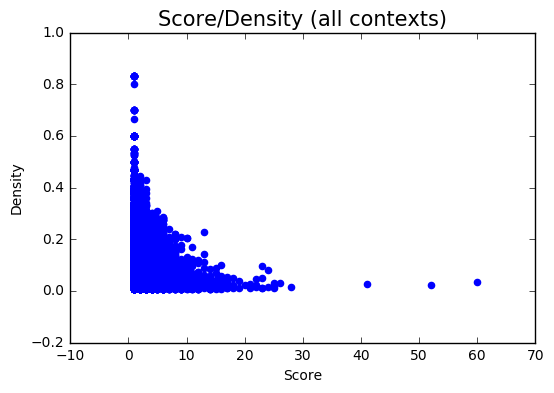

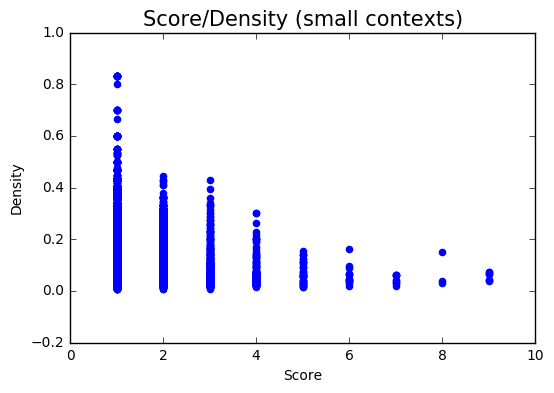

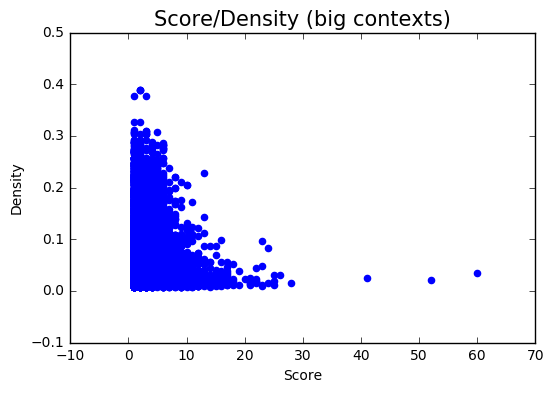

In [35]:
# Some plots 
def plot_matrix(matrix,x,y,titleX,titleY,title):
    a, b = matrix[:,x], matrix[:,y]
    
    plt.scatter(a,b, color='blue')
    plt.title(title, fontsize = 15)
    plt.xlabel(titleX, fontsize = 10)
    plt.ylabel(titleY, fontsize = 10)
    plt.show()
    plt.clf()

# Choose matrix 'small context' = < 6 translations ; 'big context' = > 5 translations
npMatrix_big = np.matrix(df.loc[df['Targets'] > 5]) # big context
npMatrix_small = np.matrix(df.loc[df['Targets'] < 6]) # small context
npMatrix = np.matrix(df)

# Change column numbers as desired

plot_matrix(npMatrix,10,7,"Score","Density","Score/Density (all contexts)")
plot_matrix(npMatrix_small,10,7,"Score","Density","Score/Density (small contexts)")
plot_matrix(npMatrix_big,10,7,"Score","Density","Score/Density (big contexts)")



Score
0.3810      20
0.4000       1
0.4286     101
0.4667     320
0.4762     402
0.5000     243
0.5238      74
0.5333    1825
0.5714      96
0.6000    3911
0.6190     314
0.6667    5772
0.7000    1329
0.7333    4324
0.7619       1
0.8000     464
0.8095       4
0.8333    4658
0.8667      37
0.9000     450
Name: Word, dtype: int64


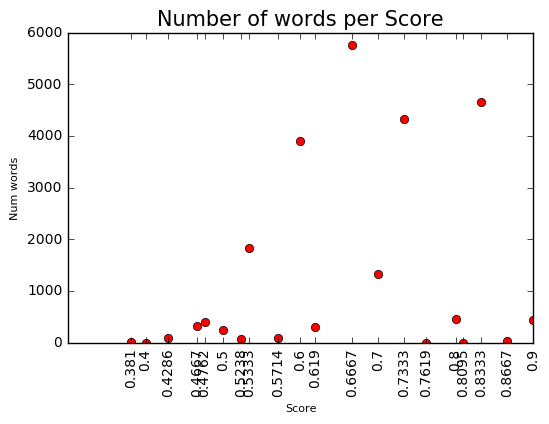

In [37]:
# List and plot number of words per Score 

#print(df.groupby('Score')['Word'].count())
tmp = df.groupby('Score')['Word'].count()
print(tmp)
size = tmp.size
xvalues = pd.Series(range(1,size))

x = tmp.index
y = tmp
labels = [str(x) for x in tmp.index]

plt.plot(x,y, 'ro')
plt.xticks(x,labels, rotation='vertical')
plt.title('Number of words per Score', fontsize = 15)
plt.xlabel('Score', fontsize = 8)
plt.ylabel('Num words', fontsize = 8)
plt.show()
plt.clf()

## Info about Target Languages

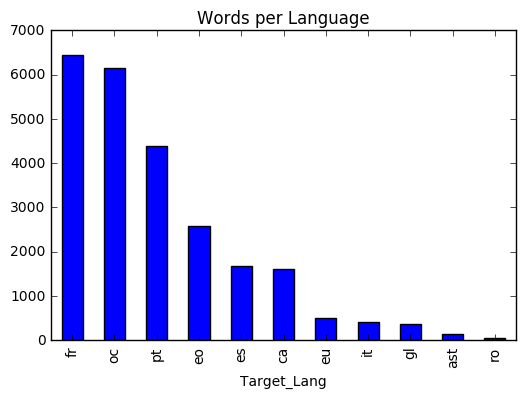

In [38]:
# Count target languages

%matplotlib inline  
#df.groupby('Target_Lang')['Word'].count().plot(kind='bar', title="Words per Language")
words = df.groupby('Target_Lang')['Word'].count()
words.sort_values(ascending=False).plot(kind='bar', title="Words per Language")
#print(words)


In [39]:
# Count 'new language' targets  (Lan column indicates if there is another translation in the same language)
lan = df.groupby('Lan')['Word'].count()
print(lan)

Lan
0    19050
1     5296
Name: Word, dtype: int64


## Listings about Potential Target words
### Source words having multiple potential targets in the same language (1toN relations):
This occurs when source word is polysemic and/or when target words are synonym. It would be nice to know ;-)!

In [40]:
# List root words having 'multiple' translations in same language
df[df.duplicated(['Word','Target_Lang'],keep=False)].sort_values(by=['Word']).head(10)

,Word,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length,Target_Lang
Target_ID,,,,,,,,,,,,,
abril-n-oc,April-n-en,142,42,15,45,4,4,0.214,0,0.7000,1,5,oc
abriu-n-oc,April-n-en,142,42,15,45,4,4,0.214,0,0.7000,1,5,oc
eskalingvo-n-eo,Basque-n-en,438,80,27,77,6,8,0.110,0,0.5333,1,6,eo
esko-n-eo,Basque-n-en,438,80,27,77,6,8,0.110,0,0.6667,4,6,eo
vasconço-n-pt,Basque-n-en,438,80,27,77,6,8,0.110,0,0.7333,2,6,pt
vasco-n-pt,Basque-n-en,438,80,27,77,6,8,0.110,0,0.7333,2,6,pt
basco-n-pt,Basque-n-en,438,80,27,77,6,8,0.110,0,0.7333,2,6,pt
crestian-n-oc,Christian-n-en,60,27,16,42,4,4,0.175,0,0.7000,1,5,oc
cristian-n-oc,Christian-n-en,60,27,16,42,4,4,0.175,0,0.7000,1,5,oc


### Multiple translations for a Potential Target word (Nto1 translations):
This occurs when two source words generate the same potential target word.

In [41]:
# List target words with 'multiple' translations
df = df.sort_index()
df[df.index.duplicated(keep=False)]

,Word,Cycles,Cycles_U,Nodes,Edges,Targets,pT,Graph_D,Lan,Score,InC,length,Target_Lang
Target_ID,,,,,,,,,,,,,
abaleire-n-oc,farmer-n-en,336,119,63,150,9,14,0.038,0,0.5333,2,6,oc
abaleire-n-oc,grazier-n-en,60,30,31,73,4,9,0.078,0,0.8333,1,4,oc
abantaila-n-eu,lead-n-en,272,26,101,194,15,6,0.019,1,0.6667,2,6,eu
abantaila-n-eu,asset-n-en,254,25,52,100,6,4,0.038,0,0.6667,2,6,eu
abasto-n-es,supply-n-en,766,280,107,247,10,17,0.022,1,0.5333,2,6,es
abasto-n-es,catering-n-en,14,7,44,85,4,7,0.045,1,0.5000,1,5,es
abesti-n-eu,edge-n-en,6696,1753,284,597,18,32,0.007,1,0.5333,1,6,eu
abesti-n-eu,singing-n-en,734,220,55,120,5,8,0.040,1,0.6000,7,5,eu
abiletat-n-oc,ability-n-en,762,126,76,155,6,7,0.027,0,0.6667,6,6,oc
